In [227]:
import graph_tool as gt
from graph_tool.draw import graph_draw
import graph_tool.collection
import graph_tool.generation as gen
import axelrod as axl
import pandas as pd
import toolz as tz
import numpy as np  
import matplotlib.pyplot as plt
from random import choice, sample
from copy import deepcopy
from collections import Counter
%matplotlib inline


In [ ]:
# project params
outputPath = './sf.png'


In [220]:
# network params
_N = 1000
_m = 2
_c = 0 
_gamma = 1

# game params
_R=1
_P=0
_T=1.5 # T€[0,2] 
_S=-.5 # S€[-1,1]

# evo params
_episode_n = 100

| p1/p2 | C | D |
| --- | --- | --- |
| C | 1 , 1 | -.5 , 1.5 |
| D | 1.5 , -.5 | 0 , 0 |

In [242]:
'''Init''' 
C = 'C'
D = 'D'
def initStrats(N) = [choice([C,D]) for i in range(N)]
def initPayoffs(N) = [0 for i in range(N)]
'''Graph'''
def initGraph(N=_N, m=_m, c=_c, gamma=_gamma) = gen.price_network(N=N, m=m, c=c, gamma=gamma, directed=False)
def getNeighborIds(id) = graph.vertex(id).out_neighbors() |> map$(int) |> list
def sampleNeighbor(id) = choice(getNeighborIds(id))
'''Games'''
def makeDilemma(R=_R, P=_P, T=_T, S=_S) = {C:{C:[R,R], D:[S,T]}, D:{C:[T,S], D:[P,P]}} # T€[0,2] S€[-1,1]
# playDilemma :: [strat] -> id -> id -> float
def playDilemma(strats, id1, id2) = dilemma[strats[id1]][strats[id2]]
# cumulativePayoffs :: graph -> [strat] # 1 round of all connections playing one another
def cumulativePayoffs(graph, strats):
    payoffs = initPayoffs(N)
    idPlayDilemma = playDilemma$(strats) 
    for [x,y] in graph.iter_edges():
        px,py = idPlayDilemma(x,y)
        payoffs[x] += px
        payoffs[y] += py
    return payoffs

'''Evolution'''
def calcK(graph, x, y) = 
    def deg(z) = graph.vertex(z).out_degree()
    max(deg(x), deg(y))
def calcD(T=_T, S=_S) = max(T, 1) - min(S, 0)
def transProb(calcK, P, x, y) = (P[y] - P[x]) / (calcK(x, y) * calcD())
# updateStrat :: graph -> [strat] -> [float] -> id -> strat
def updateStrat(graph, strats, payoffs, x) = 
    _calcK = calcK$(graph)
    y = sampleNeighbor(x)
    p = transProb(_calcK, payoffs, x, y)
    strats[x] if payoffs[x] > payoffs[y] else np.random.choice([strats[y], strats[x]], p=[p, 1-p])
# updateStrat :: graph -> [strat] -> [float] -> [strat]
def updateStrats(graph, strats, payoffs):
    _strats = deepcopy(strats)
    for x in range(N):
        _strats[x] = updateStrat(graph, _strats, payoffs, x)
    return _strats
# runEvolution :: int -> graph -> [strat] -> [float] -> [[strat]]
def runEvolution(episode_n, graph, strats, payoffs):
    episodes = [strats]
    totalPayoffs = initPayoffs(N)
    _strats = []
    for i in range(episode_n):
        payoffs = cumulativePayoffs(graph, strats)
        _strats = updateStrats(graph, strats, payoffs)
        episodes.append(deepcopy(_strats))
        totalPayoffs = np.add(totalPayoffs, payoffs)
        strats = _strats
    return totalPayoffs, episodes

def runExperiment():
    strats = initStrats(N)
    totalPayoffs = initPayoffs(N)
    totalPayoffs, episodes = runEvolution(50, graph, strats, totalPayoffs)
    return (totalPayoffs, episodes)



In [244]:
totalPayoffs, episodes = runExperiment()

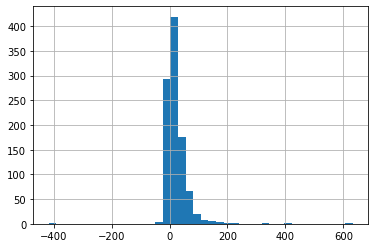

In [247]:
# Total distribution of payoffs by the end of the simulation
plotHist(totalPayoffs, 40)

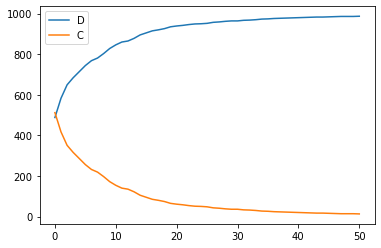

In [250]:
# Evolutions of the number of Cooperators and Defectors over time
plotStratEvo(episodes)

In [249]:
# Plots
def drawGraph(graph) = graph_draw(graph, bg_color="white") 
def plotHist(_list, bins) = pd.Series(_list).hist(bins = bins)
def plotStratEvo(episodes) = pd.DataFrame([dict(Counter(ep)) for ep in episodes]).plot.line()

In [238]:
dilemma = makeDilemma()
strats = initStrats(N)
payoffs = cumulativePayoffs(graph, strats)
episodes = runEvolution(50, graph, strats, payoffs)
